# TELSEM Atlas
I will try to re implement the logic behind the FORTRAN functions that rerad the atlas, in order to have the same data stored in a .nc file using python.

In [5]:
#
import numpy as np
import os

errorstatus_fatal = -1

The main subroutine we are interested in is called get_coordinates, and it takes the cell number and the atlas object, and returns the latitude and longitude.
---

SUBROUTINE get_coordinates(cellnum,atlas,lat,lon)
    !======computes lat and lon given the cellnumber
    IMPLICIT none
    INTEGER, INTENT (IN) :: cellnum
    type(telsem2_atlas_data), INTENT (IN) :: atlas
    REAL(jprb), INTENT (OUT) :: lat, lon
    !INTEGER :: ilat,ilon
    INTEGER :: i
    REAL :: res_lat ! latitude resolution
    INTEGER :: index_lat_max,index_lat,index_lon

    res_lat = atlas%dlat

    index_lat_max  = int(180/res_lat)

    IF (cellnum >= atlas%firstcell(index_lat_max)) THEN
       index_lat = index_lat_max
       lat =(index_lat - 0.5)*res_lat - 90
       index_lon = cellnum - atlas%firstcell(index_lat_max)+1
       lon = (index_lon - 0.5)*(360.0/atlas%ncells(index_lat))
    ELSE
       DO i=1,index_lat_max-1
          IF ( (cellnum>=atlas%firstcell(i)) .AND. (cellnum<atlas%firstcell(i+1)) ) THEN
             index_lat = i
             lat = (index_lat - 0.5)*res_lat- 90
             ! cout << i << "  " << *lat <<endl;
             index_lon = cellnum - atlas%firstcell(i)+1
             lon = (index_lon - 0.5)*(360.0/atlas%ncells(index_lat))
          END IF
       END DO
    END IF
  END SUBROUTINE get_coordinates


In [6]:
class Telsem2AtlasData:
    def __init__(self):
        # number of lines in the atlas
        self.ndat = None
        # number of channels in the atlas
        self.nchan = 7
        # name of the atlas (including version number)
        self.name = ""
        # month of the atlas
        self.month = None
        # resolution of the atlas (equal-area)
        self.dlat = 0.25
        # number of cells per lat band
        self.ncells = None
        # the first cellnumber of lat band
        self.firstcell = None
        # limits of the spatial domain (flagged if global)
        self.lat1 = None
        self.lat2 = None
        self.lon1 = None
        self.lon2 = None
        # Emissivities
        self.emis = None  # emis(ndat,nchan)
        # Correlations
        self.correl = None  # correl(10,nchan,nchan)
        # Emissivity uncertainties (std)
        self.emis_err = None  # emis_err(ndat,nchan)
        # Surface class
        self.class1 = None
        self.class2 = None
        # cellnumber of each of the pixels in the atlas
        self.cellnum = None
        # "Correspondance" vector indicating that for the ith element, the j so that EMIS(j,...) is the emissivity of cellnumber i.
        self.correspondance = None  # correspondance(660066)



In [34]:
def get_coordinates(cellnum:int, atlas: Telsem2AtlasData):

    res_lat = atlas.dlat

    index_lat_max = int(180/res_lat) - 1

    if cellnum >= atlas.firstcell[index_lat_max]:
        index_lat = index_lat_max
        lat = (index_lat - 0.5)*res_lat - 90
        index_lon = cellnum - atlas.firstcell[index_lat_max] + 1
        lon = (index_lon - 0.5)*(360.0/atlas.ncells[index_lat])

    else:
        for i in range(1,index_lat_max-1):
            if cellnum >=atlas.firstcell[i] and cellnum <atlas.firstcell[i+1]:
                index_lat = i
                lat = (index_lat -0.5)*res_lat - 90
                index_lon = cellnum - atlas.firstcell[i] + 1
                lon = (index_lon - 0.5)*(360.0/atlas.ncells[index_lat])

    return lat, lon

In [8]:
# Equal area computations

def equare(dlat, ncells, firstcell):
    # EQUAL-AREA COMPUTATIONS
    maxlat = int(180.0 / dlat)
    maxlon = int(360.0 / dlat)

    tocell = np.zeros((maxlon, maxlat), dtype=np.int32)

    REARTH = 6371.2
    PI = 2.0 * np.arcsin(1.0)
    RCELAT = (dlat * PI) / 180.0
    TOTCEL = 0

    HEZON = REARTH * np.sin(RCELAT)
    AEZON = 2.0 * PI * REARTH * HEZON
    AECELL = (AEZON * dlat) / 360.0

    MAXLT2 = maxlat // 2
    for lat in range(1, MAXLT2 + 1):
        XLATB = (lat - 1) * dlat
        XLATE = XLATB + dlat
        RLATB = (2.0 * PI * XLATB) / 360.0
        RLATE = (2.0 * PI * XLATE) / 360.0

        HTB = REARTH * np.sin(RLATB)
        HTE = REARTH * np.sin(RLATE)
        HTZONE = HTE - HTB
        AZONE = 2.0 * PI * REARTH * HTZONE

        RCELLS = AZONE / AECELL
        ICELLR = int(RCELLS + 0.5)

        TOTCEL += 2 * ICELLR

        lat1 = lat + MAXLT2
        lat2 = MAXLT2 + 1 - lat
        ncells[lat1 - 1] = ICELLR
        ncells[lat2 - 1] = ICELLR

    numcel = 0
    for lat in range(1, maxlat + 1):
        numcls = ncells[lat - 1]
        for lon in range(1, numcls + 1):
            numcel += 1
            tocell[lon - 1, lat - 1] = numcel

    for i in range(1, maxlat + 1):
        if i == 1:
            firstcell[i - 1] = 1
        else:
            firstcell[i - 1] = firstcell[i - 2] + ncells[i - 2]


Finally, mimic the functions that populate the class by reading the atlas file

In [9]:
def rttov_readmw_atlas(dir, month, atlas: Telsem2AtlasData, verbose=False, lat1=None, lat2=None, lon1=None, lon2=None):
    # Read a monthly atlas

    
    # TRANSITORY VARIABLES
    iiin = 21  # unit for input
    cellnum = 0
    ssmi = np.zeros(2 * 7, dtype=np.float64)
    lat, lon = 0.0, 0.0
    cur_class1, cur_class2 = 0, 0
    take = 0  # flag to take or not the pixel atlas for location constraints
    msg = ""

    # initialisation
    err = 0

    if atlas.emis is not None:
        err = errorstatus_fatal
        print("TELSEM2 atlas data structure already allocated")
        return err

    month2 = f"{month:02d}"

    atlas.month = month
    atlas.lat1 = -777
    atlas.lat2 = -777
    atlas.lon1 = -777
    atlas.lon2 = -777

    if lat1 is not None:
        atlas.lat1 = lat1
    if lat2 is not None:
        atlas.lat2 = lat2
    if lon1 is not None:
        atlas.lon1 = lon1 % 360.0
    if lon2 is not None:
        atlas.lon2 = lon2 % 360.0

    # ALLOCATION SPECIFIC TO SSMI ATLAS
    atlas.nchan = 7
    atlas.name = 'ssmi_mean_emis_climato'
    atlas.dlat = 0.25
    atlas.ncells = np.zeros(int(180.0 / atlas.dlat), dtype=np.int32)
    atlas.firstcell = np.zeros(int(180.0 / atlas.dlat), dtype=np.int32)
    equare(atlas.dlat, atlas.ncells, atlas.firstcell)

    # DEFINING NUMBER OF DATA
    if verbose:
        print("Reading number of data in atlas...")

    try:
        iiin_file = open(os.path.join(dir, atlas.name + '_' + month2 + '_cov_interpol_M2'), 'r')
        j = int(iiin_file.readline().strip())
        atlas.ndat = j
        if verbose:
            print(f"Nb data={atlas.ndat}")
    except IOError as e:
        print(f"Error opening the monthly input file: {e}")
        err = errorstatus_fatal
        return err

    # ALLOCATE VARIABLES
    atlas.emis = np.zeros((atlas.ndat, atlas.nchan), dtype=np.float64)
    atlas.emis_err = np.zeros((atlas.ndat, atlas.nchan), dtype=np.float64)
    atlas.class1 = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.class2 = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.cellnum = np.zeros(atlas.ndat, dtype=np.int32)
    atlas.correspondance = np.full(660066, -777, dtype=np.int32)

    ipos = 0
    for line in iiin_file:
        parts = line.strip().split()
        cellnum, ssmi_values, cur_class1, cur_class2 = int(parts[0]), list(map(float, parts[1:15])), int(parts[15]), int(parts[16])

        take = 1
        if lat1 is not None:
            get_coordinates(cellnum, atlas, lat, lon)
            if not (lat1 <= lat <= lat2 and lon1 <= lon <= lon2):
                take = 0

        if cur_class1 > 0 and cur_class2 > 0 and ipos < atlas.ndat and take == 1:
            ipos += 1
            atlas.emis[ipos - 1, :] = ssmi_values[:7]
            atlas.emis_err[ipos - 1, :] = np.sqrt(ssmi_values[7:])
            atlas.cellnum[ipos - 1] = cellnum
            atlas.class1[ipos - 1] = cur_class1
            atlas.class2[ipos - 1] = cur_class2
            atlas.correspondance[cellnum - 1] = ipos

    atlas.ndat = ipos
    iiin_file.close()

    # Correlation of uncertainties
    atlas.correl = np.zeros((10, atlas.nchan, atlas.nchan), dtype=np.float64)

    if verbose:
        print("Reading classes...")

    try:
        iiin_file = open(os.path.join(dir, 'correlations'), 'r')
        for i in range(10):
            iiin_file.readline()  # skip lines
            for j in range(7):
                atlas.correl[i, j, :] = np.array(list(map(float, iiin_file.readline().strip().split())))
    except IOError as e:
        print(f"Error opening the correlations input file: {e}")
        err = errorstatus_fatal
        return err
    finally:
        iiin_file.close()

    return err


In [59]:
# Lets try this, it wont work ...

atlas = Telsem2AtlasData()

rttov_readmw_atlas(
    dir= r"C:\Users\andre\Desktop\TELSEM\telsem2_mw_atlas",
    atlas = atlas,
    month = 2,
)

0

In [60]:
atlas.cellnum

array([    80,     81,     82, ..., 659810, 659811, 659812])

In [61]:
coordinates = get_coordinates(atlas = atlas, cellnum = atlas.cellnum[0]) 

In [62]:
# Now lets add the coordinates of each cell into a dataframe for example:

cell_numbers = atlas.cellnum

coordinates = [get_coordinates(atlas = atlas, cellnum=cn) for cn in cell_numbers]

In [44]:
coordinates[0]

(-88.875, 15.42857142857143)

In [54]:
atlas.emis.shape

(227143, 7)

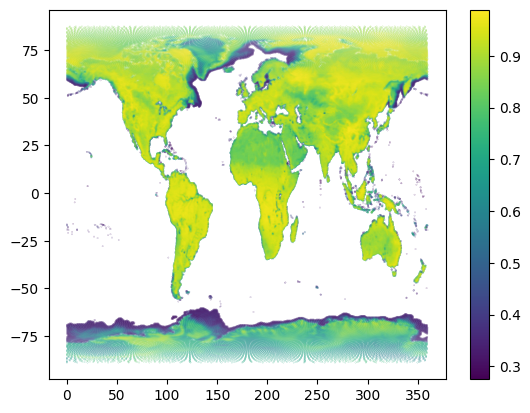

In [64]:
import matplotlib.pyplot as plt

lats = [coord[0] for coord in coordinates]
# Correct the longitudes so GM = 180

lons = [(coord[1] + 180) % 360 for coord in coordinates]

plt.scatter(lons, lats, c = atlas.emis[:,1],s=0.01 )
plt.colorbar()